# Extra libraries to install

In [ ]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Drive connection and path definition

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/final/SANDS')
path_files ='/content/drive/MyDrive/Colab Notebooks/final/UC1'

# Import libraries

In [ ]:
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
import time
from calendar import timegm, monthrange
from datetime import datetime, timedelta
import math
import sands
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow import keras
from os import listdir
from os.path import isfile, join
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import CategoricalAccuracy,Accuracy,BinaryAccuracy

# Data generation

If you want to generate new data, run the following cells, otherwise, simply load the existing csv file. Either way, the result will be the same, the metric_df data frame with the required data.

In [ ]:
parameters1 = {
        'time_delta':5
    }

In [ ]:
metric_df = sands.generate_device_metric_time_range(datetime.now(),datetime.now()+timedelta(days=30),parameters1,['PE-4'],['bng_subscribers'])


In [ ]:
metric_df.to_csv(join(path_files,'bng_subscribers_metric.csv'))

In [ ]:
metric_df=pd.read_csv(join(path_files,'bng_subscribers_metric.csv'),index_col=0)

In [ ]:
metric_df

,timestamp,bng_subscribers,device_name,vendor,model,os,version,hw_revision,role,ip_address
0,1668093542,102313.500365,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4
1,1668093842,106836.733516,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4
2,1668094142,101307.324756,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4
3,1668094442,102596.788945,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4
4,1668094742,104754.782092,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4
...,...,...,...,...,...,...,...,...,...,...
8636,1670684342,54688.767236,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4
8637,1670684642,53164.781501,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4
8638,1670684942,54137.889227,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4
8639,1670685242,53746.964249,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4


The follwing cell creates two new columns, ds and y, which are needed for Prophet later on the notebook

In [ ]:
ds_column = []
for i,obs in metric_df.iterrows():
    #new_timestamp = datetime.fromtimestamp(obs['timestamp']).strftime('%Y-%m-%d %H:%M:%S')
    new_timestamp = datetime.fromtimestamp(obs['timestamp'])
    ds_column.append(new_timestamp)
metric_df['ds']=ds_column
metric_df['y']=metric_df['bng_subscribers']



In [ ]:
metric_df

,timestamp,bng_subscribers,device_name,vendor,model,os,version,hw_revision,role,ip_address,ds,y
0,1668093542,102313.500365,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,2022-11-10 15:19:02,102313.500365
1,1668093842,106836.733516,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,2022-11-10 15:24:02,106836.733516
2,1668094142,101307.324756,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,2022-11-10 15:29:02,101307.324756
3,1668094442,102596.788945,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,2022-11-10 15:34:02,102596.788945
4,1668094742,104754.782092,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,2022-11-10 15:39:02,104754.782092
...,...,...,...,...,...,...,...,...,...,...,...,...
8636,1670684342,54688.767236,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,2022-12-10 14:59:02,54688.767236
8637,1670684642,53164.781501,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,2022-12-10 15:04:02,53164.781501
8638,1670684942,54137.889227,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,2022-12-10 15:09:02,54137.889227
8639,1670685242,53746.964249,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,2022-12-10 15:14:02,53746.964249


This is how the data looks like for the target metric:

Text(0.5, 1.0, 'BNG Subscribers')

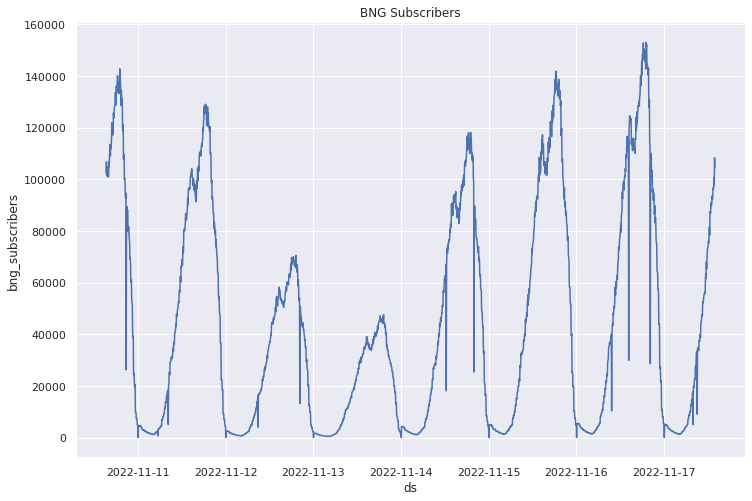

In [ ]:
# Visualize data using seaborn
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=metric_df['ds'][:2000], y=metric_df['bng_subscribers'][:2000])
plt.title('BNG Subscribers')

# Rolling window and Z-Score

In this first approach, we will use a rolling window in which we will calculate the median of the values in such window, and then we will evaluate the standard deviation. We will use those to compute what is the "normal" range of values (above and below the median) to determine the acceptable operational range for our metric of interest, and identify the anomalous values.

In [ ]:
ROLLING = 12
Z_SCORE_THRESHOLD = 3
PCTL_MULTIPLIER = 2

In [ ]:
metric_df['SMA']=metric_df.loc[:,'y'].rolling(window=ROLLING).median()
metric_df['std']=metric_df.loc[:,'y'].rolling(window=ROLLING).std()

In [ ]:
metric_df['SMA_diff']=metric_df['y']-metric_df['SMA']
metric_df['z_score']=metric_df['SMA_diff']/metric_df['std']

In [ ]:
metric_df['z_anomaly']=(abs(metric_df['z_score'])>Z_SCORE_THRESHOLD).astype(int)

In [ ]:
anomaly_df = metric_df[metric_df['z_anomaly']>0]

Text(0.5, 1.0, 'BNG Subscribers with anomalies')

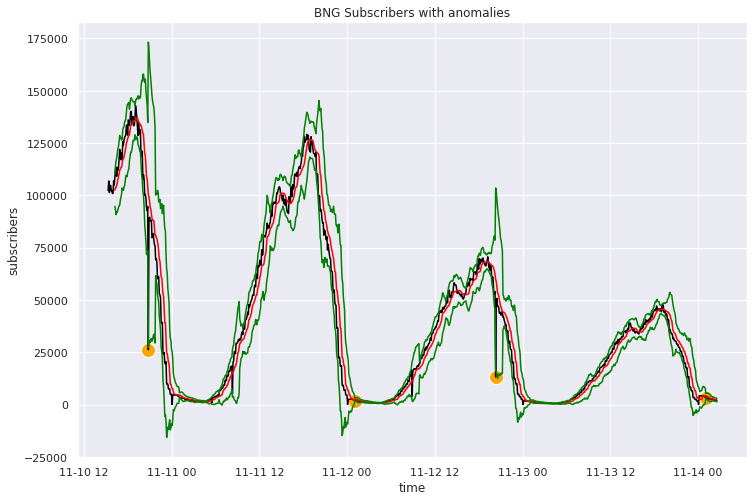

In [ ]:

anomaly_mask = anomaly_df.ds < metric_df.loc[1000,'ds']
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=metric_df['ds'][:1000], y=metric_df['y'][:1000],color='black')
sns.lineplot(x=metric_df['ds'][:1000], y=metric_df['SMA'][:1000],color='red')
sns.lineplot(x=metric_df['ds'][:1000], y=metric_df['SMA'][:1000]+Z_SCORE_THRESHOLD*metric_df['std'][:1000],color='green')
sns.lineplot(x=metric_df['ds'][:1000], y=metric_df['SMA'][:1000]-Z_SCORE_THRESHOLD*metric_df['std'][:1000],color='green')
sns.scatterplot(x=anomaly_df['ds'][anomaly_mask], y=anomaly_df['y'][anomaly_mask], color='orange',s=200)
plt.xlabel('time')
plt.ylabel('subscribers')
plt.title('BNG Subscribers with anomalies')

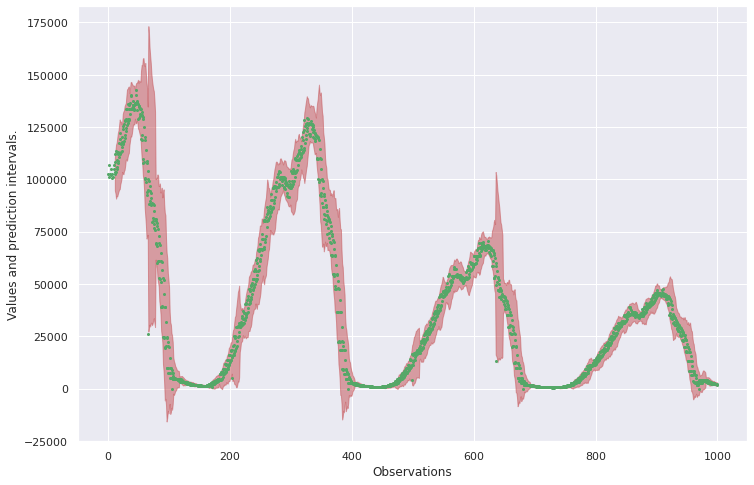

In [ ]:
plt.plot(metric_df['y'][:1000],'go',markersize=2,label='Actual')
plt.plot(metric_df['SMA'][:1000],'go',markersize=2,label='Actual')
plt.fill_between(
       np.arange(1000), metric_df['SMA'][:1000]-Z_SCORE_THRESHOLD*metric_df['std'][:1000], metric_df['SMA'][:1000]+Z_SCORE_THRESHOLD*metric_df['std'][:1000], alpha=0.5, color="r",
label="Predicted interval")
plt.xlabel("Observations")
plt.ylabel("Values and prediction intervals.")
plt.show()

In [ ]:
metric_df['pctl']= np.abs(metric_df['SMA_diff']).rolling(window=ROLLING).quantile(0.95,interpolation='lower')
metric_df['z_anomaly_2']=((np.abs(metric_df['SMA_diff'])/metric_df['pctl'])>PCTL_MULTIPLIER).astype(int)
anomaly_2_df = metric_df[metric_df['z_anomaly_2']>0]

Text(0.5, 1.0, 'BNG Subscribers with anomalies')

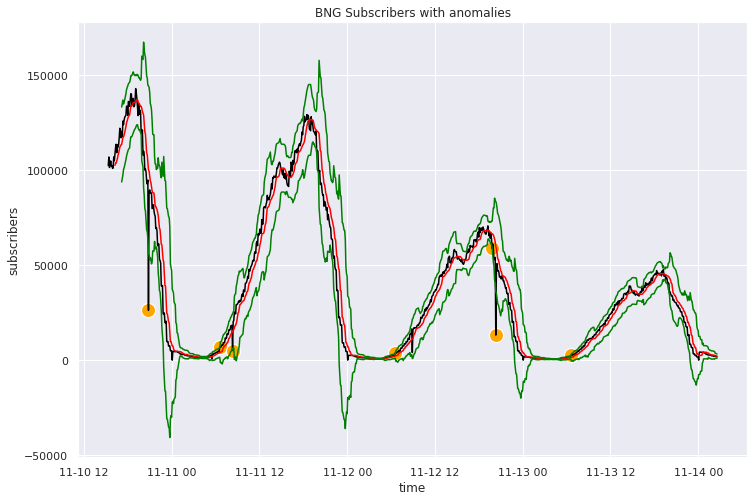

In [ ]:
anomaly_mask = anomaly_2_df.ds < metric_df.loc[1000,'ds']
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=metric_df['ds'][:1000], y=metric_df['y'][:1000],color='black')
sns.lineplot(x=metric_df['ds'][:1000], y=metric_df['SMA'][:1000],color='red')
sns.lineplot(x=metric_df['ds'][:1000], y=metric_df['SMA'][:1000]+PCTL_MULTIPLIER*metric_df['pctl'][:1000],color='green')
sns.lineplot(x=metric_df['ds'][:1000], y=metric_df['SMA'][:1000]-PCTL_MULTIPLIER*metric_df['pctl'][:1000],color='green')
sns.scatterplot(x=anomaly_2_df['ds'][anomaly_mask], y=anomaly_2_df['y'][anomaly_mask], color='orange',s=200)
plt.xlabel('time')
plt.ylabel('subscribers')
plt.title('BNG Subscribers with anomalies')

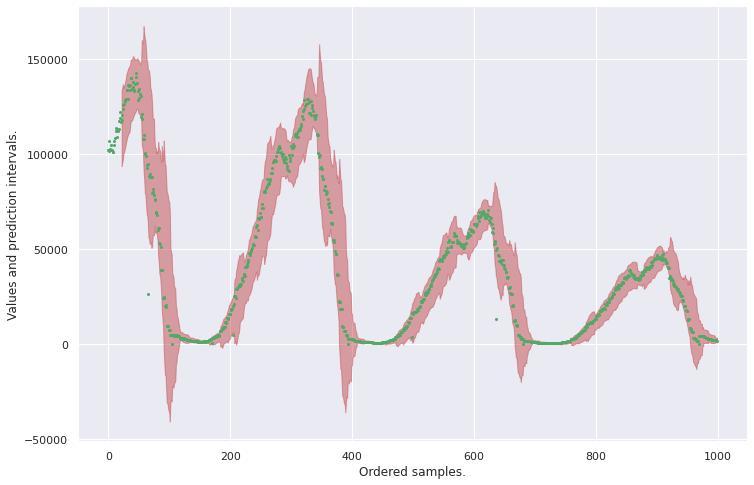

In [ ]:
plt.plot(metric_df['y'][:1000],'go',markersize=2,label='Actual')
plt.fill_between(
       np.arange(1000), metric_df['SMA'][:1000]-PCTL_MULTIPLIER*metric_df['pctl'][:1000], metric_df['SMA'][:1000]+PCTL_MULTIPLIER*metric_df['pctl'][:1000], alpha=0.5, color="r",
label="Predicted interval")
plt.xlabel("Ordered samples.")
plt.ylabel("Values and prediction intervals.")
plt.show()

# Prophet

In this section we will by applying Facebook's Prophet library to detect anomalies on the bng_subscribers metric

In [ ]:
m = Prophet().fit(metric_df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2hcmrz_i/o1ibbcps.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2hcmrz_i/qihu9rxa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71464', 'data', 'file=/tmp/tmp2hcmrz_i/o1ibbcps.json', 'init=/tmp/tmp2hcmrz_i/qihu9rxa.json', 'output', 'file=/tmp/tmp2hcmrz_i/prophet_modelvyd8u6a6/prophet_model-20221214122800.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:28:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:28:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


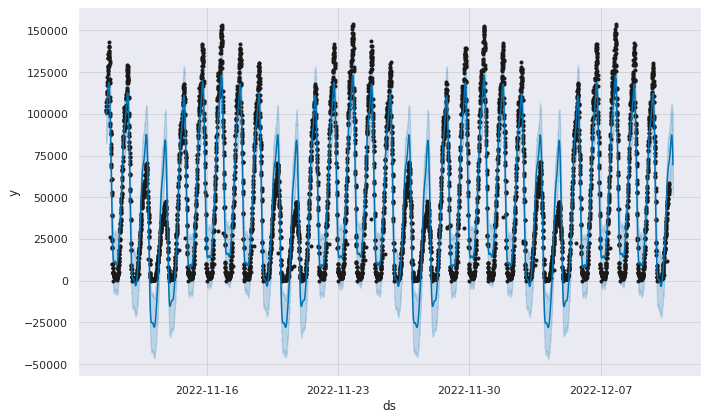

In [ ]:
future = m.make_future_dataframe(periods=300, freq='min')
fcst = m.predict(future)
fig = m.plot(fcst)

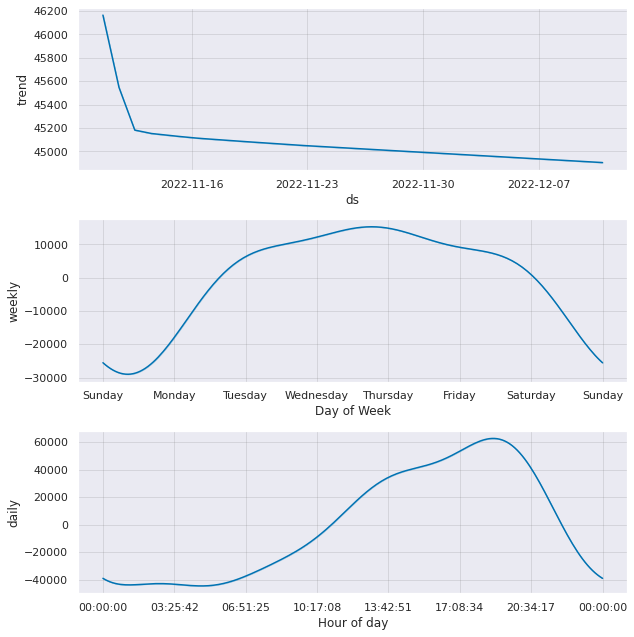

In [ ]:
fig = m.plot_components(fcst)

In [ ]:
fcst

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-11-10 15:19:02,46165.192947,82321.463113,116233.841144,46165.192947,46165.192947,53275.781542,53275.781542,53275.781542,42289.880665,42289.880665,42289.880665,10985.900878,10985.900878,10985.900878,0.0,0.0,0.0,99440.974490
1,2022-11-10 15:24:02,46162.971910,83971.591418,117038.479996,46162.971910,46162.971910,53584.389984,53584.389984,53584.389984,42620.526987,42620.526987,42620.526987,10963.862998,10963.862998,10963.862998,0.0,0.0,0.0,99747.361894
2,2022-11-10 15:29:02,46160.750872,83050.467640,115855.654860,46160.750872,46160.750872,53902.848799,53902.848799,53902.848799,42960.957204,42960.957204,42960.957204,10941.891595,10941.891595,10941.891595,0.0,0.0,0.0,100063.599671
3,2022-11-10 15:34:02,46158.529835,81278.858932,117679.012699,46158.529835,46158.529835,54233.317889,54233.317889,54233.317889,43313.330370,43313.330370,43313.330370,10919.987519,10919.987519,10919.987519,0.0,0.0,0.0,100391.847724
4,2022-11-10 15:39:02,46156.308797,84249.320392,115971.267583,46156.308797,46156.308797,54577.801253,54577.801253,54577.801253,43679.649648,43679.649648,43679.649648,10898.151605,10898.151605,10898.151605,0.0,0.0,0.0,100734.110050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8936,2022-12-10 20:15:02,44905.047762,53940.915308,89096.063314,44905.047762,44905.047762,26012.648867,26012.648867,26012.648867,48056.546478,48056.546478,48056.546478,-22043.897611,-22043.897611,-22043.897611,0.0,0.0,0.0,70917.696629
8937,2022-12-10 20:16:02,44905.042166,53581.492630,87642.763205,44905.042166,44905.042166,25660.209413,25660.209413,25660.209413,47721.617502,47721.617502,47721.617502,-22061.408089,-22061.408089,-22061.408089,0.0,0.0,0.0,70565.251579
8938,2022-12-10 20:17:02,44905.036570,52489.030463,87203.143158,44905.036570,44905.036570,25304.342709,25304.342709,25304.342709,47383.245798,47383.245798,47383.245798,-22078.903089,-22078.903089,-22078.903089,0.0,0.0,0.0,70209.379279
8939,2022-12-10 20:18:02,44905.030975,53370.516081,87229.239443,44905.030975,44905.030975,24945.074152,24945.074152,24945.074152,47041.456731,47041.456731,47041.456731,-22096.382579,-22096.382579,-22096.382579,0.0,0.0,0.0,69850.105127


In [ ]:
# Merge actual and predicted values
combined_results = pd.merge(metric_df, fcst[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')


In [ ]:
combined_results['anomaly'] = combined_results.apply(lambda rows: 1 if ((rows.y<rows.yhat_lower)|(rows.y>rows.yhat_upper)) else 0, axis = 1)
combined_results['anomaly'].value_counts()

0    7140
1    1501
Name: anomaly, dtype: int64

In [ ]:
anomalies = combined_results[combined_results['anomaly']==1].sort_values(by='ds')
anomalies

,timestamp,bng_subscribers,device_name,vendor,model,os,version,hw_revision,role,ip_address,...,z_score,z_anomaly,99_pctl,z_anomaly_2,95_pctl,pctl,yhat,yhat_lower,yhat_upper,anomaly
30,1668102542,133524.756312,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,...,1.720325,0,8729.153100,0,9318.052390,8759.665957,115367.948610,98532.595185,132956.787273,1
31,1668102842,133496.604078,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,...,1.323562,0,8729.153100,0,8690.276939,8633.504106,115932.185869,99141.560609,132860.732110,1
33,1668103442,136021.524899,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,...,1.504354,0,8730.925774,0,8690.276939,8633.504106,116957.738676,99260.790739,134330.353770,1
34,1668103742,135636.271281,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,...,1.344755,0,8730.925774,0,8690.276939,8633.504106,117409.714729,100377.550807,133924.304328,1
36,1668104342,136290.226382,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,...,1.208998,0,8004.771967,0,8364.488448,8041.161396,118168.751260,101023.102669,135303.816095,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8434,1670623742,15630.418466,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,...,-3.229338,1,53813.223805,1,33695.401980,15944.382723,44107.840652,27147.255848,61388.366303,1
8609,1670676242,11780.972679,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,...,-3.088982,1,25077.316551,1,15798.770372,7611.817861,56476.881138,39435.523010,74653.247196,1
8637,1670684642,53164.781501,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,...,-1.153837,0,3938.815089,0,4705.314941,4332.697695,70222.264473,53568.884559,86562.191893,1
8639,1670685242,53746.964249,PE-4,Juniper,MX960,Junos,21.3R1,hw3958888,PE,10.2.2.4,...,-0.984331,0,2319.917034,0,4705.314941,4332.697695,70649.216857,54117.568050,87421.476691,1


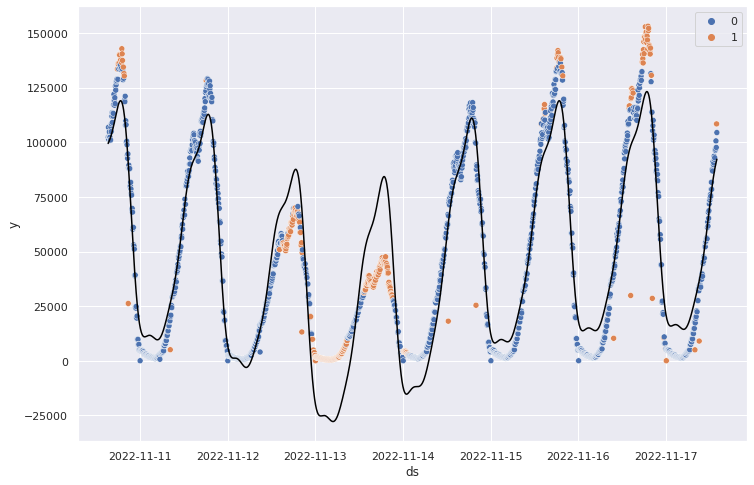

In [ ]:
# Let's visualize the anomalies
sns.scatterplot(x='ds', y='y', data=combined_results[:2000], hue='anomaly')
sns.lineplot(x='ds', y='yhat', data=combined_results[:2000], color='black')

# LSTM based autoencoder

We will start exploring the possibility to detect anomalies using Neural Networks and deep learning. In particular in this case, we will start with using a sequence based autoencoder. The sequence based aspect results in the approach of using LSTM. LSTM is well built for sequences, so the intuition says that it may be a good choice. However, it has been reported that LSTM does not work specially well with auto-regresive signals, so we will need to check how well in performs in our case.

In [ ]:
time_steps = 72

In [ ]:
train_pct = 0.95
train_size = int(metric_df.shape[0]*0.95)
test_size = metric_df.shape[0]-train_size

In [ ]:
scaler = StandardScaler()
scaler = scaler.fit(metric_df[['y']])
metric_df['y_scaled']=scaler.transform(metric_df[['y']])


In [ ]:
metric_df.y_scaled.shape

(8641,)

In [ ]:
Xs, ys = [], []
for i in range(metric_df.shape[0] - time_steps):
    v = metric_df[['y_scaled']].iloc[i:(i + time_steps)].values
    Xs.append(v)
    ys.append(metric_df.y_scaled.iloc[i + time_steps-1])
x = np.array(Xs) 
y = np.array(ys)

In [ ]:
x.shape

(8569, 72, 1)

In [ ]:
y.shape

(8569,)

In [ ]:
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
model = keras.Sequential()
model.add(keras.layers.LSTM(units=128,input_shape=(x_train.shape[1],x_train.shape[2]),return_sequences=False))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=x_train.shape[1]))
model.add(keras.layers.LSTM(units=128,return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=x_train.shape[2])))
model.add(keras.layers.Dropout(rate=0.2))

model.compile(loss='mse',optimizer ='adam',metrics=['mse'])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 repeat_vector_4 (RepeatVect  (None, 72, 128)          0         
 or)                                                             
                                                                 
 lstm_9 (LSTM)               (None, 72, 128)           131584    
                                                                 
 dropout_13 (Dropout)        (None, 72, 128)           0         
                                                                 
 time_distributed_4 (TimeDis  (None, 72, 1)            129       
 tributed)                                            

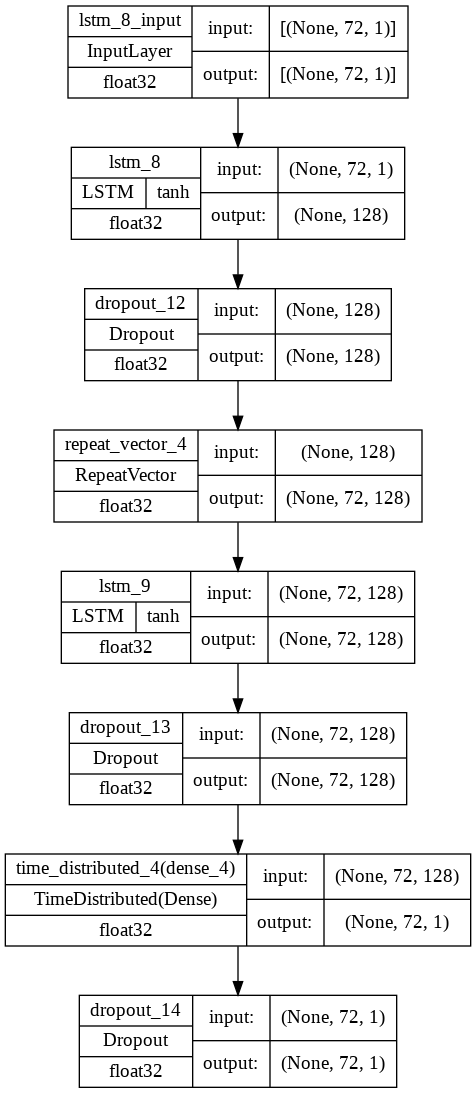

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True,show_dtype=True,show_layer_names=True,show_layer_activations=True)

In [ ]:
filepath=join(path_files,"weights_autoencoder_auto_mse_best.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='mse', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
model.load_weights(filepath)

OSError: ignored

In [ ]:
history = model.fit(x_train,x_train, epochs =50 , batch_size=128,validation_split=0.1,shuffle = False,callbacks=callbacks_list,verbose=1)

Epoch 1/50
56/58 [===========================>..] - ETA: 0s - loss: 0.5532 - mse: 0.5532
Epoch 1: mse improved from inf to 0.54981, saving model to /content/drive/MyDrive/Colab Notebooks/final/UC1/weights_autoencoder_auto_mse_300_best.hdf5
58/58 [==============================] - 34s 39ms/step - loss: 0.5498 - mse: 0.5498 - val_loss: 0.6464 - val_mse: 0.6464
Epoch 2/50
56/58 [===========================>..] - ETA: 0s - loss: 0.4143 - mse: 0.4143
Epoch 2: mse improved from 0.54981 to 0.41552, saving model to /content/drive/MyDrive/Colab Notebooks/final/UC1/weights_autoencoder_auto_mse_300_best.hdf5
58/58 [==============================] - 1s 16ms/step - loss: 0.4155 - mse: 0.4155 - val_loss: 0.5164 - val_mse: 0.5164
Epoch 3/50
56/58 [===========================>..] - ETA: 0s - loss: 0.3931 - mse: 0.3931
Epoch 3: mse improved from 0.41552 to 0.39401, saving model to /content/drive/MyDrive/Colab Notebooks/final/UC1/weights_autoencoder_auto_mse_300_best.hdf5
58/58 [========================

In [ ]:
model.save_weights(filepath)

In [ ]:
model.save(join(path_files,'anomaly_model_autoencoder_best'))

In [ ]:
# list all data available in history
print(history.history.keys())

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


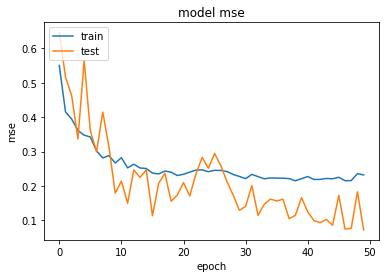

In [ ]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



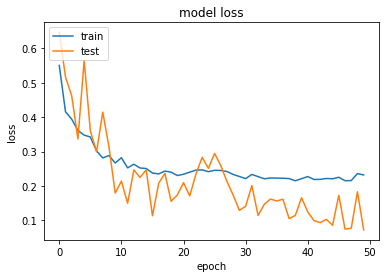

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_test_pred = model.predict(x_test)

12/12 [==============================] - 1s 6ms/step


In [ ]:
score, acc = model.evaluate(x_test, x_test)

12/12 [==============================] - 0s 7ms/step - loss: 0.0469 - mse: 0.0469


In [ ]:
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 0.04691780358552933
Test accuracy: 0.04691780358552933


The "predicted" values are effectively vectors of lenght 72. 

In [ ]:
y_test_pred.shape

(361, 72, 1)

In [ ]:
y_test_pred_complete = y_test_pred

We are going to take only the last value of each vector as the "predicted" value from the model. We know it has predicted an entire vector, but for the purposes of visualizing the results of the model, we will use only the last value.

In [ ]:
y_test_pred = y_test_pred[:,71,0]

In [ ]:
y_test_pred.shape

(361,)

In [ ]:
y_test_pred = y_test_pred.reshape(-1,1)

In [ ]:
y_test.shape

(361,)

In [ ]:
y_test = y_test.reshape(-1,1)

In [ ]:
y_test.shape

(361, 1)

In [ ]:
x_test.shape

(361, 72, 1)

In [ ]:
test_mae_loss = np.abs(y_test_pred - y_test)


In [ ]:
test_mae_loss.shape

(361, 1)

In [ ]:
#test_mae_loss = np.mean(np.abs(y_test_pred - y_test), axis=1)
test_mae_loss = np.abs(y_test_pred - y_test)

THRESHOLD = np.percentile(test_mae_loss, 99)

test_score_df = pd.DataFrame(index=metric_df[(train_size + time_steps):].ds)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['y'] = y_test
test_score_df['y_pred']=y_test_pred

anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,y,y_pred
ds,,,,,
2022-12-09 17:54:02,0.621182,0.61778,True,1.760252,1.139070
2022-12-09 18:24:02,0.681575,0.61778,True,1.928689,1.247114
2022-12-09 18:34:02,0.661477,0.61778,True,1.949085,1.287608
2022-12-09 22:14:02,0.799747,0.61778,True,-0.679392,0.120355


In [ ]:
test_score_df

,loss,threshold,anomaly,y,y_pred
ds,,,,,
2022-12-09 09:19:02,0.007035,0.597263,False,-0.311819,-0.304784
2022-12-09 09:24:02,0.033454,0.597263,False,-0.327053,-0.293599
2022-12-09 09:29:02,0.035546,0.597263,False,-0.323735,-0.288189
2022-12-09 09:34:02,0.023749,0.597263,False,-0.259295,-0.283044
2022-12-09 09:39:02,0.003288,0.597263,False,-0.268575,-0.265287
...,...,...,...,...,...
2022-12-10 14:59:02,0.097779,0.597263,False,0.216562,0.118783
2022-12-10 15:04:02,0.076777,0.597263,False,0.181604,0.104827
2022-12-10 15:09:02,0.118765,0.597263,False,0.203926,0.085161


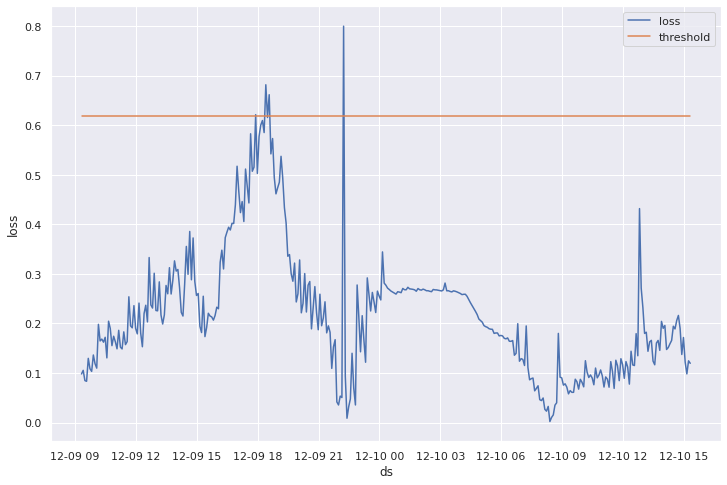

In [ ]:
sns.lineplot(x= test_score_df.index, y= test_score_df.loss,label='loss')
sns.lineplot(x = test_score_df.index, y =test_score_df.threshold,label='threshold')

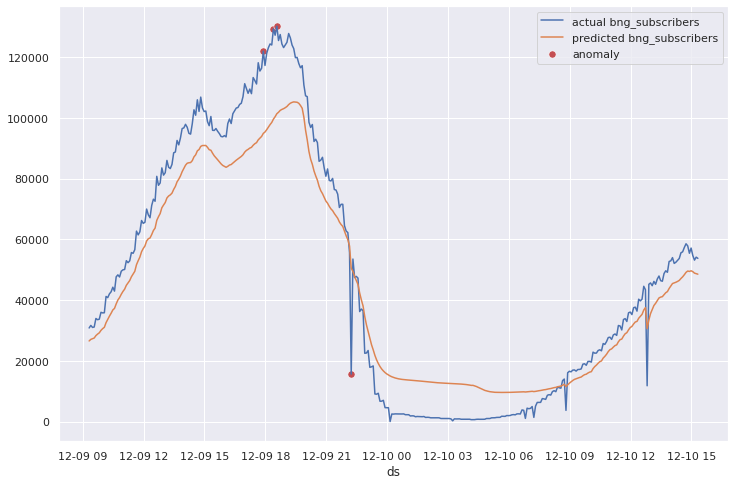

In [ ]:
sns.lineplot(
      x= test_score_df.index, 
      y= scaler.inverse_transform(test_score_df.y.values.reshape(1,-1)).reshape(-1), 
      label='actual bng_subscribers'
    )

sns.lineplot(
      x= test_score_df.index, 
      y= scaler.inverse_transform(test_score_df.y_pred.values.reshape(1,-1)).reshape(-1), 
      label='predicted bng_subscribers'
    )

sns.scatterplot(
      x= anomalies.index,
      y= scaler.inverse_transform(anomalies.y.values.reshape(1,-1)).reshape(-1),
      color=sns.color_palette()[3],
      s=52,
      label='anomaly'
    )

In [ ]:
y_pred = model.predict(x)

268/268 [==============================] - 1s 5ms/step


In [ ]:
y_pred=y_pred[:,-1,0]

In [ ]:
y_pred=y_pred.reshape(-1,1)

In [ ]:
y = y.reshape(-1,1)
mae_loss = np.abs(y_pred - y)

mae_threshold = np.percentile(mae_loss, 99)

score_df = pd.DataFrame(index=metric_df[(time_steps):].ds)
score_df['loss'] = mae_loss
score_df['threshold'] = mae_threshold
score_df['anomaly'] = score_df.loss > score_df.threshold
score_df['y'] = y
score_df['y_pred']=y_pred

total_anomalies = score_df[score_df.anomaly == True]
total_anomalies.head()

,loss,threshold,anomaly,y,y_pred
ds,,,,,
2022-11-12 20:24:02,0.811657,0.568238,True,-0.735807,0.075850
2022-11-14 12:29:02,0.716746,0.568238,True,-0.622437,0.094309
2022-11-14 20:04:02,1.273933,0.568238,True,-0.455294,0.818639
2022-11-16 13:54:02,0.643295,0.568238,True,1.630608,0.987313
2022-11-16 13:59:02,0.605381,0.568238,True,1.612140,1.006759


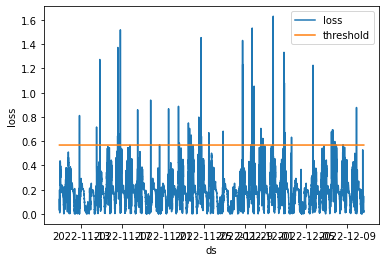

In [ ]:
sns.lineplot(x= score_df.index, y= score_df.loss,label='loss')
sns.lineplot(x = score_df.index, y =score_df.threshold,label='threshold')

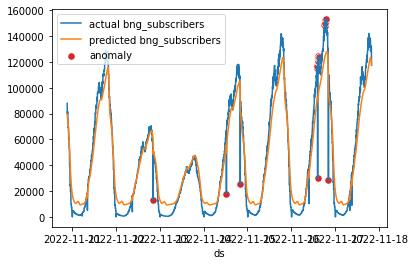

In [ ]:
scope = 2000
scope_time = score_df.index[scope]
anomaly_scope = total_anomalies.index <= scope_time
sns.lineplot(
      x= score_df[:scope].index, 
      y= scaler.inverse_transform(score_df[:scope].y.values.reshape(1,-1)).reshape(-1), 
      label='actual bng_subscribers'
    )

sns.lineplot(
      x= score_df[:scope].index, 
      y= scaler.inverse_transform(score_df[:scope].y_pred.values.reshape(1,-1)).reshape(-1), 
      label='predicted bng_subscribers'
    )

sns.scatterplot(
      x= total_anomalies[anomaly_scope].index,
      y= scaler.inverse_transform(total_anomalies[anomaly_scope].y.values.reshape(1,-1)).reshape(-1),
      color=sns.color_palette()[3],
      s=52,
      label='anomaly'
    )

# Feed Forward Dense layers based Autoencoder

In [ ]:
time_steps = 2016


In [ ]:
Xs, ys = [], []
for i in range(metric_df.shape[0] - time_steps):
    v = metric_df[['y_scaled']].iloc[i:(i + time_steps)].values
    Xs.append(v)
    ys.append(metric_df.y_scaled.iloc[i + time_steps-1])
x = np.array(Xs) 
y = np.array(ys)

In [ ]:
x.shape

(6625, 2016, 1)

In [ ]:
y.shape

(6625,)

In [ ]:
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
model = keras.Sequential()

model.add(keras.layers.Dense(units=1024,input_shape=(x_train.shape[1],),activation='tanh'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=512,activation='tanh'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=128,activation='tanh'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=512,activation='tanh'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=x_train.shape[1]))
model.add(keras.layers.Dropout(rate=0.2))

opt = keras.optimizers.Adam(learning_rate=0.0005)

model.compile(loss='mse',optimizer =opt,metrics=['mse'])

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 1024)              2065408   
                                                                 
 dropout_20 (Dropout)        (None, 1024)              0         
                                                                 
 dense_11 (Dense)            (None, 512)               524800    
                                                                 
 dropout_21 (Dropout)        (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 128)               65664     
                                                                 
 dropout_22 (Dropout)        (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 512)              

In [ ]:
filepath=join(path_files,"weights_autoencoder_dense_mse_best.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='mse', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(x_train,x_train, epochs =50 , batch_size=128,validation_split=0.1,shuffle = False,callbacks=callbacks_list,verbose=1)

Epoch 1/50
38/47 [=======================>......] - ETA: 0s - loss: 0.5980 - mse: 0.5980
Epoch 1: mse improved from inf to 0.57649, saving model to /content/drive/MyDrive/Colab Notebooks/final/UC1/weights_autoencoder_dense_mse_best.hdf5
47/47 [==============================] - 1s 13ms/step - loss: 0.5765 - mse: 0.5765 - val_loss: 0.2822 - val_mse: 0.2822
Epoch 2/50
39/47 [=======================>......] - ETA: 0s - loss: 0.4428 - mse: 0.4428
Epoch 2: mse improved from 0.57649 to 0.43928, saving model to /content/drive/MyDrive/Colab Notebooks/final/UC1/weights_autoencoder_dense_mse_best.hdf5
47/47 [==============================] - 0s 10ms/step - loss: 0.4393 - mse: 0.4393 - val_loss: 0.2435 - val_mse: 0.2435
Epoch 3/50
38/47 [=======================>......] - ETA: 0s - loss: 0.4269 - mse: 0.4269
Epoch 3: mse improved from 0.43928 to 0.42439, saving model to /content/drive/MyDrive/Colab Notebooks/final/UC1/weights_autoencoder_dense_mse_best.hdf5
47/47 [==============================] - 

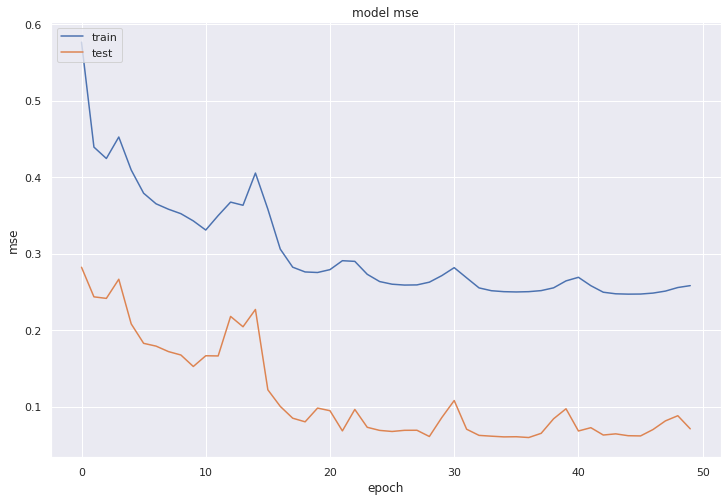

In [ ]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save_weights(filepath)

In [ ]:
y_pred = model.predict(x)

208/208 [==============================] - 0s 2ms/step


In [ ]:
y_pred.shape

(6625, 2016)

In [ ]:
y_pred=y_pred[:,-1]

In [ ]:
y_pred.shape

(6625,)

In [ ]:
y_pred=y_pred.reshape(-1,1)
y = y.reshape(-1,1)

In [ ]:

mae_loss = np.abs(y_pred - y)

mae_threshold = np.percentile(mae_loss, 99)

score_df = pd.DataFrame(index=metric_df[(time_steps):].ds)
score_df['loss'] = mae_loss
score_df['threshold'] = mae_threshold
score_df['anomaly'] = score_df.loss > score_df.threshold
score_df['y'] = y
score_df['y_pred']=y_pred

total_anomalies = score_df[score_df.anomaly == True]
total_anomalies.head()

,loss,threshold,anomaly,y,y_pred
ds,,,,,
2022-11-18 12:49:02,1.069862,0.668259,True,-0.558016,0.511846
2022-11-18 18:14:02,0.679292,0.668259,True,1.908152,1.228860
2022-11-18 19:09:02,0.695825,0.668259,True,1.961135,1.265309
2022-11-18 19:14:02,0.707497,0.668259,True,1.958668,1.251171
2022-11-18 19:19:02,0.680195,0.668259,True,1.918188,1.237993


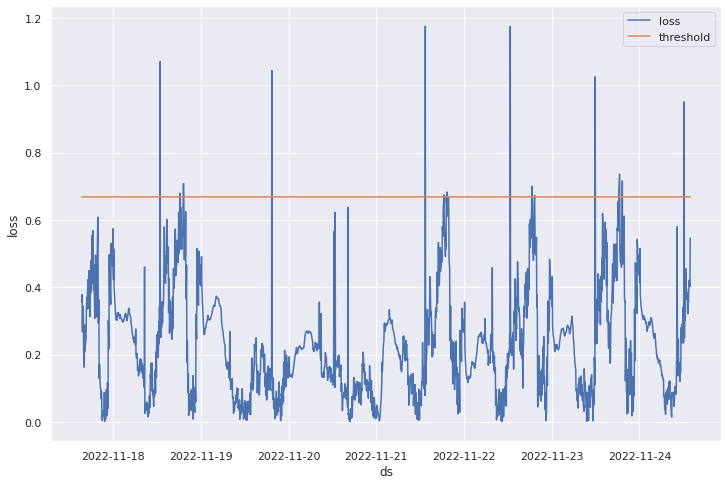

In [ ]:
sns.lineplot(x= score_df[:scope].index, y= score_df[:scope].loss,label='loss')
sns.lineplot(x = score_df[:scope].index, y =score_df[:scope].threshold,label='threshold')

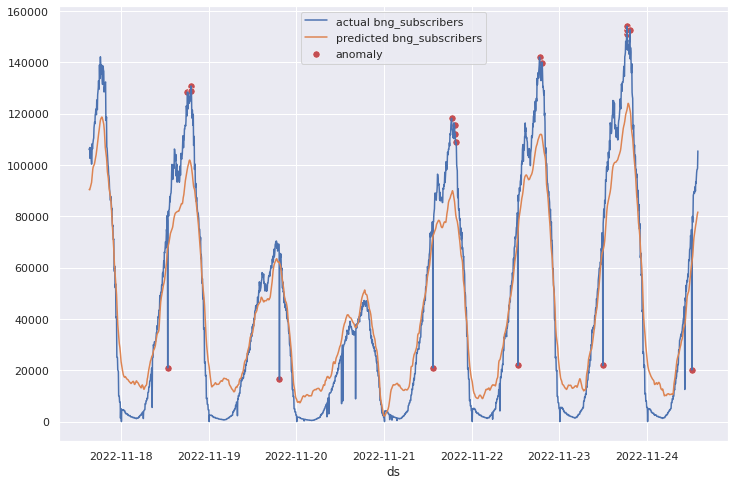

In [ ]:
scope = 2000
scope_time = score_df.index[scope]
anomaly_scope = total_anomalies.index <= scope_time
sns.lineplot(
      x= score_df[:scope].index, 
      y= scaler.inverse_transform(score_df[:scope].y.values.reshape(1,-1)).reshape(-1), 
      label='actual bng_subscribers'
    )

sns.lineplot(
      x= score_df[:scope].index, 
      y= scaler.inverse_transform(score_df[:scope].y_pred.values.reshape(1,-1)).reshape(-1), 
      label='predicted bng_subscribers'
    )

sns.scatterplot(
      x= total_anomalies[anomaly_scope].index,
      y= scaler.inverse_transform(total_anomalies[anomaly_scope].y.values.reshape(1,-1)).reshape(-1),
      color=sns.color_palette()[3],
      s=52,
      label='anomaly'
    )